In [1]:
#Config GPU Nvidia 1660 Ti
%run "c:\tf\tf_config.py"

***PlantVillage Disease Classification Challenge*** [Crowd AI] \
https://www.aicrowd.com/challenges/plantvillage-disease-classification-challenge-old

In [183]:
import os
root_dir = 'd:/Datasets/PlantLeaf'
source_dir = root_dir + "/Plants"
train_dir = root_dir + "/training"
validation_dir = root_dir + "/validation"
test_dir = root_dir + "/testing"
os.makedirs(root_dir, exist_ok=True)

In [189]:
import os
import numpy as np
import shutil
import random

val_ratio = 0.15
test_ratio = 0.05

def copy_files(Directory, Files):
    for name in Files:
        orig = source_directory + '/' + directory + '/' + name
        dest = Directory + '/' + directory + '/' + name
        try:
            shutil.copy(orig, dest)
        except:
            pass
        
print("Creating Directory Structure {}". format(root_dir))
categories = os.listdir(source_dir)

for directory in (categories):
    if not os.path.exists(train_dir + '/' + directory): os.makedirs(train_dir + '/' + directory)
    if not os.path.exists(validation_dir + '/' + directory): os.makedirs(validation_dir + '/' + directory)
    if not os.path.exists(test_dir + '/' + directory): os.makedirs(test_dir + '/' + directory)
        
# Creating partitions of the data after shuffeling
for directory in (categories):
    allFileNames =  os.listdir(source_dir + "/" + directory + "/")
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio + test_ratio)), 
                                                              int(len(allFileNames)* (1 - test_ratio))])
    # Copy-pasting images
    print("Starting to copy Files on Directory: {}:".format(directory))
    copy_files(train_dir, train_FileNames)
    copy_files(val_dir, val_FileNames)
    copy_files(test_dir, test_FileNames)

Creating Directory Structure d:/Datasets/PlantLeaf
Starting to copy Files on Directory: Apple___Apple_scab:
Starting to copy Files on Directory: Apple___Black_rot:
Starting to copy Files on Directory: Apple___Cedar_apple_rust:
Starting to copy Files on Directory: Apple___healthy:
Starting to copy Files on Directory: Background_without_leaves:
Starting to copy Files on Directory: Blueberry___healthy:
Starting to copy Files on Directory: Cherry___healthy:
Starting to copy Files on Directory: Cherry___Powdery_mildew:
Starting to copy Files on Directory: Corn___Cercospora_leaf_spot Gray_leaf_spot:
Starting to copy Files on Directory: Corn___Common_rust:
Starting to copy Files on Directory: Corn___healthy:
Starting to copy Files on Directory: Corn___Northern_Leaf_Blight:
Starting to copy Files on Directory: Grape___Black_rot:
Starting to copy Files on Directory: Grape___Esca_(Black_Measles):
Starting to copy Files on Directory: Grape___healthy:
Starting to copy Files on Directory: Grape___L

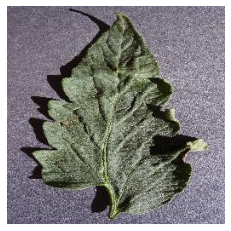

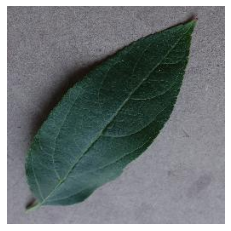

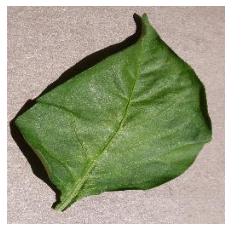

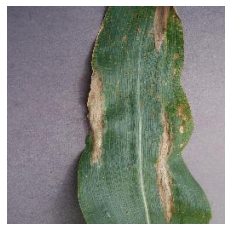

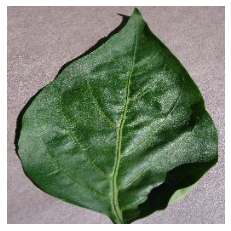

In [190]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

for i in range(5):
    directory = [os.path.join(train_directory + '/' + np.random.choice(categories))]
    chosendir = np.random.choice(directory)
    plants =  os.listdir(chosendir)
    plant = chosendir + '/' + np.random.choice(plants)
    plt.imshow(image.load_img(chosendir + '/' + np.random.choice(plants)))
    plt.axis('off')
    plt.show()  


In [191]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [192]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [194]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(39, activation='softmax'))

In [195]:
print('Este es el número de tensores de pesos entrenables antes de freezar la base convolucional:', len(model.trainable_weights))
conv_base.trainable = False
print('Este es el número de tensores de pesos entrenables después de freezar la base convolucional:', len(model.trainable_weights))

Este es el número de tensores de pesos entrenables antes de freezar la base convolucional: 30
Este es el número de tensores de pesos entrenables después de freezar la base convolucional: 4


In [196]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_13 (Dense)             (None, 39)                10023     
Total params: 16,822,119
Trainable params: 2,107,431
Non-trainable params: 14,714,688
_________________________________________________________________


In [197]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Definimos un generador de imágenes aumentadas
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# ¡Notar que la data de validación no debe ser aumentada!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Directorio target
        train_dir,
        # Reescalamos a 150x150
        target_size=(150, 150),
        batch_size=20,
        # Usamos binary_crossentropy y etiquetas binarias
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

Found 49882 images belonging to 39 classes.
Found 2773 images belonging to 39 classes.


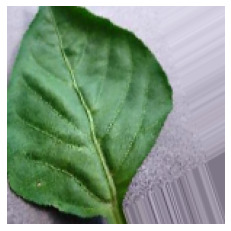

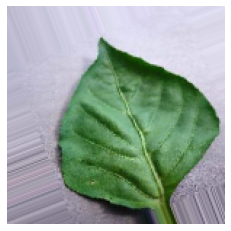

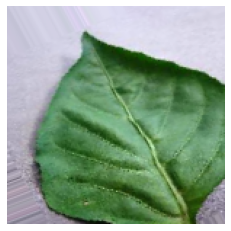

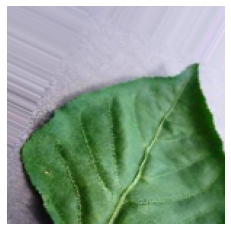

In [198]:
# Elegimos una imagen para "aumentar"
img_path = plant

# La leemos y la reescalamos
img = image.load_img(plant, target_size=(150, 150))

# La convertimos a un Numpy de forma (150, 150, 3)
x = image.img_to_array(img)

# La reescalamos a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El comando .flow() genera batches de imágenes transformadas aleatoriamente
# Usamos un `break` para cortar el loop en algún momento
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    plt.axis('off')
    i += 1
    if i % 4 == 0:
        break

In [199]:
from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) 
classWeight = dict(enumerate(classWeight))

In [200]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      class_weight=classWeight,
      verbose=1)

Epoch 1/30
100/100 [==============================] - 11s 114ms/step - loss: 0.1160 - acc: 0.1810 - val_loss: 0.0742 - val_acc: 0.4400
Epoch 2/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0905 - acc: 0.3255 - val_loss: 0.0571 - val_acc: 0.5790
Epoch 3/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0727 - acc: 0.4520 - val_loss: 0.0416 - val_acc: 0.6550
Epoch 4/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0656 - acc: 0.5080 - val_loss: 0.0372 - val_acc: 0.7080
Epoch 5/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0571 - acc: 0.5670 - val_loss: 0.0308 - val_acc: 0.7720
Epoch 6/30
100/100 [==============================] - 11s 113ms/step - loss: 0.0500 - acc: 0.6075 - val_loss: 0.0270 - val_acc: 0.7820
Epoch 7/30
100/100 [==============================] - 12s 116ms/step - loss: 0.0530 - acc: 0.5820 - val_loss: 0.0329 - val_acc: 0.7520
Epoch 8/30
100/100 [==============================] - 1

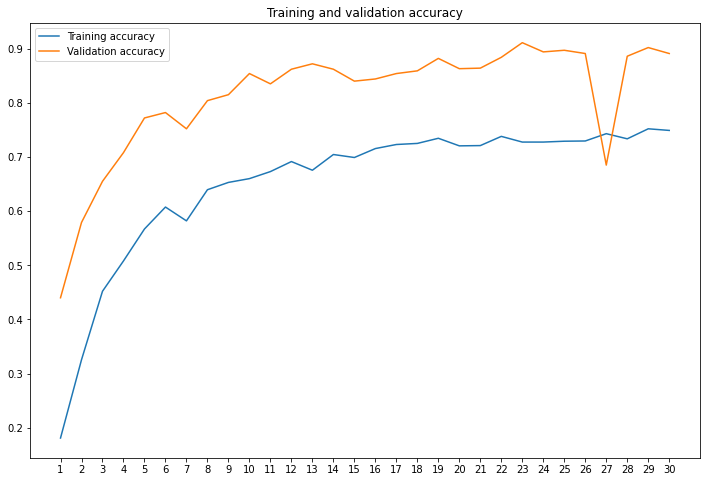

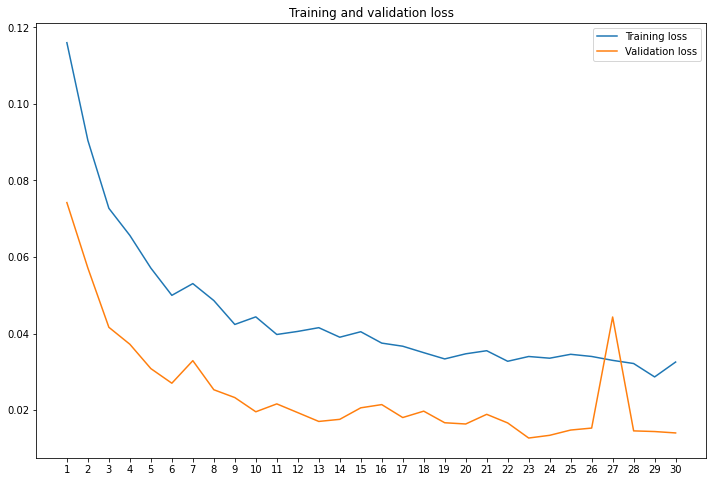

In [201]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()

***Probando con Modelo desde cero***

In [202]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(39, activation='softmax'))

In [203]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

In [204]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      class_weight=classWeight,
      verbose=1)

Epoch 1/30
100/100 [==============================] - 10s 97ms/step - loss: 0.1164 - acc: 0.0325 - val_loss: 0.1129 - val_acc: 0.0600
Epoch 2/30
100/100 [==============================] - 9s 95ms/step - loss: 0.1178 - acc: 0.0414 - val_loss: 0.1170 - val_acc: 0.0200
Epoch 3/30
100/100 [==============================] - 10s 96ms/step - loss: 0.1163 - acc: 0.0415 - val_loss: 0.1128 - val_acc: 0.0580
Epoch 4/30
100/100 [==============================] - 10s 97ms/step - loss: 0.1145 - acc: 0.0380 - val_loss: 0.1131 - val_acc: 0.0600
Epoch 5/30
100/100 [==============================] - 10s 95ms/step - loss: 0.1198 - acc: 0.0405 - val_loss: 0.1106 - val_acc: 0.1070
Epoch 6/30
100/100 [==============================] - 10s 96ms/step - loss: 0.1161 - acc: 0.0455 - val_loss: 0.1037 - val_acc: 0.1230
Epoch 7/30
100/100 [==============================] - 9s 95ms/step - loss: 0.1083 - acc: 0.0725 - val_loss: 0.1012 - val_acc: 0.1450
Epoch 8/30
100/100 [==============================] - 9s 95ms/st

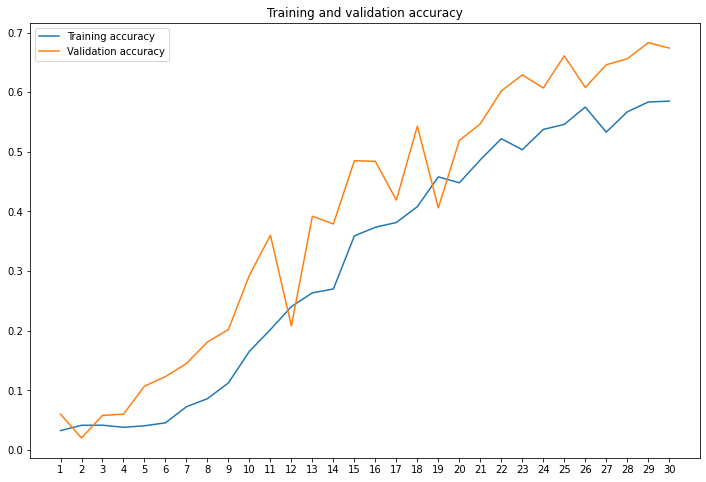

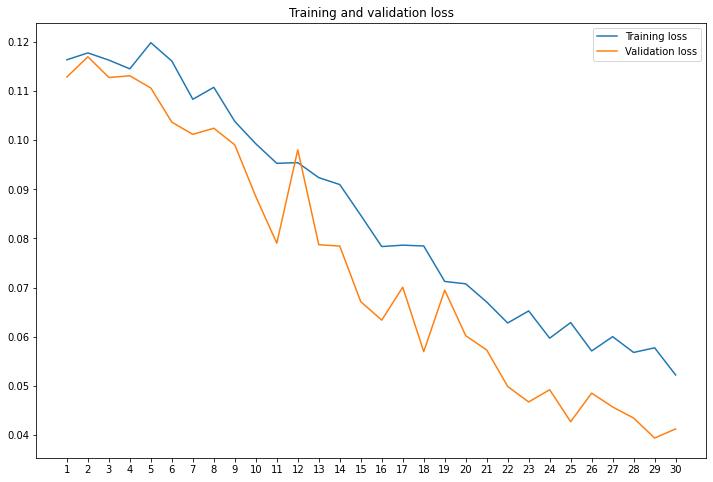

In [205]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))
plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xticks(ticks=epochs)
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(12,8))
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xticks(ticks=epochs)
plt.title('Training and validation loss')
plt.legend()
plt.show()